In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import os

#dataframes
# import pandas as pd
# import h5py
# import rosbag_pandas

#math
import numpy as np
import math
# pd.TimeSeries = pd.Series 

#interpolation scipy
import scipy
from scipy import signal
import scipy.interpolate as interpolate
from scipy import integrate

#gps
from geopy import distance
#import geopandas as gpd
import utm
import datetime as dt

#plots
import pylab as plt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation  


font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 28}
PLT_LW = 3

matplotlib.rc('font', **font)



In [2]:
folders = {
'zig-zag':"BOTFLY_DATA_2021-07-28-16-00-54"
}
raw_data_home_folder_name = '../data_experiments_raw/raw_botfly_data'
preprocessed_data_home_folder_name = '../data_experiments_preprocessed'

In [4]:
folder = folders['zig-zag']
folder_name = folder.split("/")[-1]
files = [folder_name + "-mavros-global_position-global.csv",
         folder_name + "-mavros-imu-data.csv",
         folder_name + "-mavros-rc-in.csv",
         folder_name + "-optic_flow_mean_vx.csv",
         folder_name + "-optic_flow_mean_vy.csv",
         folder_name + "-trisonica.csv"
        ]
wind_df = pd.read_hdf(os.path.join(preprocessed_data_home_folder_name, "2021728_183722_windgps_data_horizontal.hdf"))
wind_df_v = pd.read_hdf(os.path.join(preprocessed_data_home_folder_name, "2021728_183846_windgps_data_vertical.hdf"))
wind_df['Stationary_Vertical_Wind'] = wind_df_v.W

DFs = [
    pd.read_csv( os.path.join(raw_data_home_folder_name, folder + "/" + file_name)) for file_name in files
]

/home/caveman/BMD2/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


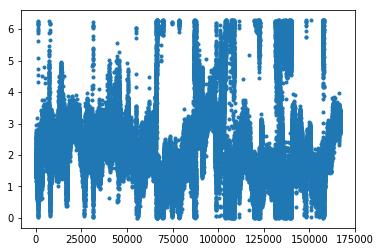

In [5]:
plt.plot(np.radians(wind_df.D.values), '.')

In [6]:
def clean_df(df, r_list=['covariance','frame_id','twist_twist_agular','seq']):
#     df.columns=df.columns.str.replace(r"/", "_")
    for r in r_list:
        df = df[df.columns.drop(list(df.filter(regex=r)))]
    return df

In [7]:
def fix_date(date):
    datetimeObj = datetime.strptime(date, '%Y/%m/%d/%H:%M:%S.%f')
    return datetime.timestamp(datetimeObj)

In [8]:
DFs[0].rename(columns={'time':'gps_time',
                       '.longitude':'lon',
                       '.latitude':'lat',
                       '.altitude':'alt'}, inplace=True)
DFs[0].rename(columns={'index':'master_time'}, inplace=True)
DFs[0].gps_time = DFs[0].gps_time.map(lambda date: fix_date(date))
    
DFs[1].rename(columns={'time':'imu_time'}, inplace=True)
DFs[1].rename(columns={'.orientation.x':'orientation_x',
                       '.orientation.y':'orientation_y',
                       '.orientation.z':'orientation_z',
                       '.angular_velocity.x':'angular_velocity_x',
                       '.angular_velocity.y':'angular_velocity_y',
                       '.angular_velocity.z':'angular_velocity_z',
                       '.linear_acceleration.x':'linear_acceleration_x',
                       '.linear_acceleration.y':'linear_acceleration_y',
                       '.linear_acceleration.z':'linear_acceleration_z'}, inplace=True)
DFs[1].rename(columns={'index':'master_time'}, inplace=True)
DFs[1].imu_time = DFs[1].imu_time.map(lambda date: fix_date(date))
    
DFs[2].rename(columns={'time':'rc_time',
                       '.channels':'channels'}, inplace=True)
DFs[2].rename(columns={'index':'master_time'}, inplace=True)
DFs[2].rc_time = DFs[2].rc_time.map(lambda date: fix_date(date))
channel_data = np.vstack([eval(row) for row in DFs[2].channels.values])
for i in range(7):
    DFs[2]['ch'+str(i)] = channel_data[:,i]

In [9]:
DFs[3].rename(columns={'time':'OpFlo_vx_time',
                       '.data':'OpFlo_vx'}, inplace=True)
DFs[3].rename(columns={'index':'master_time'}, inplace=True)
DFs[3].OpFlo_vx_time = DFs[3].OpFlo_vx_time.map(lambda date: fix_date(date))
    
DFs[4].rename(columns={'time':'OpFlo_vy_time',
                       '.data':'OpFlo_vy'}, inplace=True)
DFs[4].rename(columns={'index':'master_time'}, inplace=True)
DFs[4].OpFlo_vy_time = DFs[4].OpFlo_vy_time.map(lambda date: fix_date(date))
    
DFs[5].rename(columns={'time':'trisonica_time',
                       '.northsouth':'north_south',
                       '.updown':'up_down',
                       '.westeast':'west_east'}, inplace=True)
DFs[5].rename(columns={'index':'master_time'}, inplace=True)
DFs[5].trisonica_time = DFs[5].trisonica_time.map(lambda date: fix_date(date))

#remove rc data since we wont be using it
# del DFs[2]
DF = pd.concat(DFs)

/home/caveman/BMD2/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [10]:
DFs[5].keys()

Index(['trisonica_time', '.header.seq', '.header.stamp.secs',
       '.header.stamp.nsecs', '.header.frame_id', '.speed', 'north_south',
       'west_east', 'up_down', '.temperature'],
      dtype='object')

In [11]:
rl = ["millis","lat","lon","gps_time","gps_date", "wind","gps_date_str",
     "year","month","day","gps_time_str","hour","minute","second"]
wind_df = clean_df(wind_df, r_list=rl)
wind_df.rename(columns={'time_epoch':'ground_wind_time', "D":"Dir", "S2":"Speed"}, inplace=True)

In [12]:
wind_df["Dir"] = np.radians(wind_df.Dir)

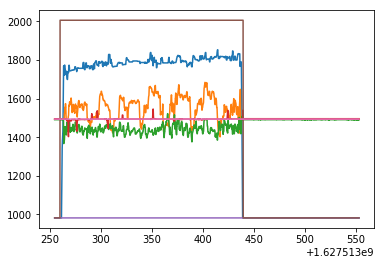

In [13]:
# print(DF.ch0[DF.ch0.notna()])
ch0_d = DF.ch0[DF.ch0.notna()]
rc_t = DF.rc_time[DF.ch0.notna()]
plt.plot(rc_t, ch0_d)
# plt.show()

# print(DF.ch1[DF.ch1.notna()])
ch1_d = DF.ch1[DF.ch1.notna()]
rc_t = DF.rc_time[DF.ch1.notna()]
plt.plot(rc_t, ch1_d)
# plt.show()

# print(DF.ch2[DF.ch2.notna()])
ch2_d = DF.ch2[DF.ch2.notna()]
rc_t = DF.rc_time[DF.ch2.notna()]
plt.plot(rc_t, ch2_d)
# plt.show()

# print(DF.ch3[DF.ch3.notna()])
ch3_d = DF.ch3[DF.ch3.notna()]
rc_t = DF.rc_time[DF.ch3.notna()]
plt.plot(rc_t, ch3_d)
# plt.show()

# print(DF.ch4[DF.ch4.notna()])
ch4_d = DF.ch4[DF.ch4.notna()]
rc_t = DF.rc_time[DF.ch4.notna()]
plt.plot(rc_t, ch4_d)
# plt.show()

# print(DF.ch5[DF.ch5.notna()])
ch5_d = DF.ch5[DF.ch5.notna()]
rc_t = DF.rc_time[DF.ch5.notna()]
plt.plot(rc_t, ch5_d)
# plt.show()

# print(DF.ch6[DF.ch6.notna()])
ch6_d = DF.ch6[DF.ch6.notna()]
rc_t = DF.rc_time[DF.ch6.notna()]
plt.plot(rc_t, ch6_d)
plt.show()

In [14]:
DF = DF[DF.ch5 > 1000]
# DF = DF[DF.drop(DF[DF.ch5 < 1000])]
# DF[DF.ch5 > 1000]

In [15]:
new_DFs = [DFs[1], DFs[0], DFs[3], DFs[4], DFs[5], DFs[2]]
DF = pd.concat(new_DFs, sort=True)
combined_time = np.hstack([DFs[1].imu_time ,DFs[0].gps_time, DFs[3].OpFlo_vx_time, DFs[4].OpFlo_vy_time, DFs[5].trisonica_time, DFs[2].rc_time])
DF['time'] = combined_time
DF = DF.sort_values(by=["time"])
# DF = DF[DF.ch5 > 1000]

In [16]:
# print(DF)
print(DF.keys())
DF

Index(['.angular_velocity_covariance', '.header.frame_id', '.header.seq',
       '.header.stamp.nsecs', '.header.stamp.secs',
       '.linear_acceleration_covariance', '.orientation.w',
       '.orientation_covariance', '.position_covariance',
       '.position_covariance_type', '.rssi', '.speed', '.status.service',
       '.status.status', '.temperature', 'OpFlo_vx', 'OpFlo_vx_time',
       'OpFlo_vy', 'OpFlo_vy_time', 'alt', 'angular_velocity_x',
       'angular_velocity_y', 'angular_velocity_z', 'ch0', 'ch1', 'ch2', 'ch3',
       'ch4', 'ch5', 'ch6', 'channels', 'gps_time', 'imu_time', 'lat',
       'linear_acceleration_x', 'linear_acceleration_y',
       'linear_acceleration_z', 'lon', 'north_south', 'orientation_x',
       'orientation_y', 'orientation_z', 'rc_time', 'trisonica_time',
       'up_down', 'west_east', 'time'],
      dtype='object')


,.angular_velocity_covariance,.header.frame_id,.header.seq,.header.stamp.nsecs,.header.stamp.secs,.linear_acceleration_covariance,.orientation.w,.orientation_covariance,.position_covariance,.position_covariance_type,...,lon,north_south,orientation_x,orientation_y,orientation_z,rc_time,trisonica_time,up_down,west_east,time
0,NaN,base_link,0.0,571401152.0,1.627513e+09,NaN,NaN,NaN,"(5.597956000000001, 0.0, 0.0, 0.0, 5.597956000...",2.0,...,-119.766012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.627513e+09
1,NaN,base_link,1.0,591401152.0,1.627513e+09,NaN,NaN,NaN,"(5.597956000000001, 0.0, 0.0, 0.0, 5.597956000...",2.0,...,-119.766012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.627513e+09
2,NaN,base_link,2.0,611401152.0,1.627513e+09,NaN,NaN,NaN,"(5.597956000000001, 0.0, 0.0, 0.0, 5.597956000...",2.0,...,-119.766012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.627513e+09
3,NaN,base_link,3.0,631401152.0,1.627513e+09,NaN,NaN,NaN,"(5.597956000000001, 0.0, 0.0, 0.0, 5.597956000...",2.0,...,-119.766012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.627513e+09
4,NaN,base_link,4.0,651400384.0,1.627513e+09,NaN,NaN,NaN,"(5.597956000000001, 0.0, 0.0, 0.0, 5.597956000...",2.0,...,-119.766012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.627513e+09
5,NaN,base_link,5.0,671400384.0,1.627513e+09,NaN,NaN,NaN,"(5.597956000000001, 0.0, 0.0, 0.0, 5.597956000...",2.0,...,-119.766012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.627513e+09
0,"(1.2184696791468346e-07, 0.0, 0.0, 0.0, 1.2184...",base_link,10942.0,680400384.0,1.627513e+09,"(8.999999999999999e-08, 0.0, 0.0, 0.0, 8.99999...",-0.793218,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)",NaN,NaN,...,NaN,NaN,0.022502,-0.001772,0.608520,NaN,NaN,NaN,NaN,1.627513e+09
6,NaN,base_link,6.0,691400384.0,1.627513e+09,NaN,NaN,NaN,"(5.597956000000001, 0.0, 0.0, 0.0, 5.597956000...",2.0,...,-119.766012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.627513e+09
1,"(1.2184696791468346e-07, 0.0, 0.0, 0.0, 1.2184...",base_link,10943.0,700400384.0,1.627513e+09,"(8.999999999999999e-08, 0.0, 0.0, 0.0, 8.99999...",-0.793216,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)",NaN,NaN,...,NaN,NaN,0.022499,-0.001774,0.608522,NaN,NaN,NaN,NaN,1.627513e+09
7,NaN,base_link,7.0,710400384.0,1.627513e+09,NaN,NaN,NaN,"(5.597956000000001, 0.0, 0.0, 0.0, 5.597956000...",2.0,...,-119.766012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.627513e+09


In [17]:
dt_imu = np.median(np.diff(DF.imu_time.dropna().values))
dt_gps = np.median(np.diff(DF.gps_time.dropna().values))
dt_ofx = np.median(np.diff(DF.OpFlo_vx_time.dropna().values))
dt_ofy = np.median(np.diff(DF.OpFlo_vy_time.dropna().values))
dt_tri = np.median(np.diff(DF.trisonica_time.dropna().values))
dt_rc = np.median(np.diff(DF.rc_time.dropna().values))
dts = [dt_imu, dt_gps, dt_ofx, dt_ofy, dt_tri, dt_rc]

print(dts)

first_time = np.max([DF.imu_time.min(), DF.gps_time.min(), DF.OpFlo_vx_time.min(),
                     DF.OpFlo_vy_time.min(), DF.trisonica_time.min(), DF.rc_time.min()])
last_time = np.min([DF.imu_time.max(), DF.gps_time.max(), DF.OpFlo_vx_time.max(),
                     DF.OpFlo_vy_time.max(), DF.trisonica_time.max(), DF.rc_time.max()])

master_time = np.arange(first_time, last_time, min(dts))

[0.020016908645629883, 0.019982099533081055, 0.03330087661743164, 0.03329896926879883, 0.025054931640625, 0.049878597259521484]


In [18]:
DF.keys()

Index(['.angular_velocity_covariance', '.header.frame_id', '.header.seq',
       '.header.stamp.nsecs', '.header.stamp.secs',
       '.linear_acceleration_covariance', '.orientation.w',
       '.orientation_covariance', '.position_covariance',
       '.position_covariance_type', '.rssi', '.speed', '.status.service',
       '.status.status', '.temperature', 'OpFlo_vx', 'OpFlo_vx_time',
       'OpFlo_vy', 'OpFlo_vy_time', 'alt', 'angular_velocity_x',
       'angular_velocity_y', 'angular_velocity_z', 'ch0', 'ch1', 'ch2', 'ch3',
       'ch4', 'ch5', 'ch6', 'channels', 'gps_time', 'imu_time', 'lat',
       'linear_acceleration_x', 'linear_acceleration_y',
       'linear_acceleration_z', 'lon', 'north_south', 'orientation_x',
       'orientation_y', 'orientation_z', 'rc_time', 'trisonica_time',
       'up_down', 'west_east', 'time'],
      dtype='object')

In [19]:
df_imu_ornt_x = DF[['imu_time', 'orientation_x']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_ornt_x.imu_time, df_imu_ornt_x.orientation_x)
interp_imu_ornt_x = func_interp_sensor(master_time)

df_imu_ornt_y = DF[['imu_time', 'orientation_y']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_ornt_y.imu_time, df_imu_ornt_y.orientation_y)
interp_imu_ornt_y = func_interp_sensor(master_time)

df_imu_ornt_z = DF[['imu_time', 'orientation_z']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_ornt_z.imu_time, df_imu_ornt_z.orientation_z)
interp_imu_ornt_z = func_interp_sensor(master_time)


df_imu_ang_vel_x = DF[['imu_time', 'angular_velocity_x']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_ang_vel_x.imu_time, df_imu_ang_vel_x.angular_velocity_x)
interp_imu_ang_vel_x = func_interp_sensor(master_time)

df_imu_ang_vel_y = DF[['imu_time', 'angular_velocity_y']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_ang_vel_y.imu_time, df_imu_ang_vel_y.angular_velocity_y)
interp_imu_ang_vel_y = func_interp_sensor(master_time)

df_imu_ang_vel_z = DF[['imu_time', 'angular_velocity_z']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_ang_vel_z.imu_time, df_imu_ang_vel_z.angular_velocity_z)
interp_imu_ang_vel_z = func_interp_sensor(master_time)


df_imu_lin_accel_x = DF[['imu_time', 'linear_acceleration_x']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_lin_accel_x.imu_time, df_imu_lin_accel_x.linear_acceleration_x)
interp_imu_lin_accel_x = func_interp_sensor(master_time)

df_imu_lin_accel_y = DF[['imu_time', 'linear_acceleration_y']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_lin_accel_y.imu_time, df_imu_lin_accel_y.linear_acceleration_y)
interp_imu_lin_accel_y = func_interp_sensor(master_time)

df_imu_lin_accel_z = DF[['imu_time', 'linear_acceleration_z']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_lin_accel_z.imu_time, df_imu_lin_accel_z.linear_acceleration_z)
interp_imu_lin_accel_z = func_interp_sensor(master_time)




df_gps_lon = DF[['gps_time', 'lon']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_gps_lon.gps_time, df_gps_lon.lon)
interp_gps_lon = func_interp_sensor(master_time)

df_gps_lat = DF[['gps_time', 'lat']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_gps_lat.gps_time, df_gps_lat.lat)
interp_gps_lat = func_interp_sensor(master_time)

df_gps_alt = DF[['gps_time', 'alt']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_gps_alt.gps_time, df_gps_alt.alt)
interp_gps_alt = func_interp_sensor(master_time)




df_opflo_vx = DF[['OpFlo_vx_time', 'OpFlo_vx']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_opflo_vx.OpFlo_vx_time, df_opflo_vx.OpFlo_vx)
interp_opflo_vx = func_interp_sensor(master_time)

df_opflo_vy = DF[['OpFlo_vy_time', 'OpFlo_vy']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_opflo_vy.OpFlo_vy_time, df_opflo_vy.OpFlo_vy)
interp_opflo_vy = func_interp_sensor(master_time)




df_trison_NS = DF[['trisonica_time', 'north_south']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_trison_NS.trisonica_time, df_trison_NS.north_south)
interp_trison_NS = func_interp_sensor(master_time)

df_trison_WE = DF[['trisonica_time', 'west_east']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_trison_WE.trisonica_time, df_trison_WE.west_east)
interp_trison_WE = func_interp_sensor(master_time)

df_trison_UD = DF[['trisonica_time', 'up_down']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_trison_UD.trisonica_time, df_trison_UD.up_down)
interp_trison_UD = func_interp_sensor(master_time)



df_ch0 = DF[['rc_time', 'ch0']].dropna()
print(df_ch0.shape)
func_interp_sensor = scipy.interpolate.interp1d(df_ch0.rc_time, df_ch0.ch0)
interp_ch0 = func_interp_sensor(master_time)

df_ch1 = DF[['rc_time', 'ch1']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_ch1.rc_time, df_ch1.ch1)
interp_ch1 = func_interp_sensor(master_time)

df_ch2 = DF[['rc_time', 'ch2']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_ch2.rc_time, df_ch2.ch2)
interp_ch2 = func_interp_sensor(master_time)

df_ch3 = DF[['rc_time', 'ch3']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_ch3.rc_time, df_ch3.ch3)
interp_ch3 = func_interp_sensor(master_time)

df_ch4 = DF[['rc_time', 'ch4']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_ch4.rc_time, df_ch4.ch4)
interp_ch4 = func_interp_sensor(master_time)

df_ch5 = DF[['rc_time', 'ch5']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_ch5.rc_time, df_ch5.ch5)
interp_ch5 = func_interp_sensor(master_time)

(5961, 2)


# Fix trig here

In [20]:
interp_opflo_ang = np.arctan2(interp_opflo_vx, interp_opflo_vy)
interp_opflo_mag = np.sqrt(interp_opflo_vy**2 + interp_opflo_vx**2)

interp_drone_wind_ang = np.arctan2(interp_trison_WE, interp_trison_NS)
interp_drone_wind_mag = np.sqrt(interp_trison_WE**2 + interp_trison_NS**2)

# fix declination
#interp_drone_wind_ang -= 13*np.pi/180. # reno declination = +13

# flip to tell direction wind is going to
#interp_drone_wind_ang -= np.pi

/home/caveman/BMD2/lib/python3.5/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


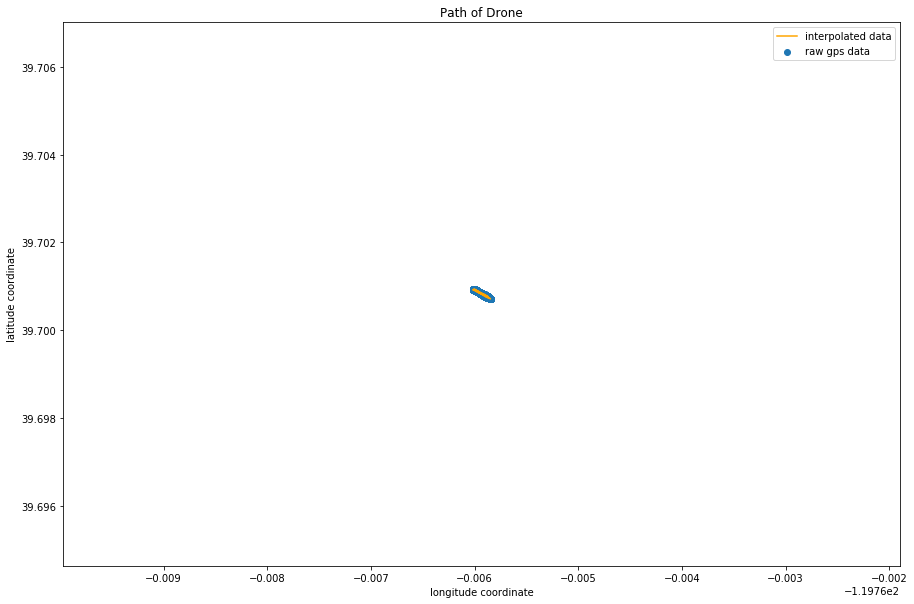

In [21]:
plt.figure(figsize=(15,10))
plt.scatter(DF['lon'], DF['lat'], label='raw gps data')
plt.plot(interp_gps_lon, interp_gps_lat, color='orange', label='interpolated data')
plt.title("Path of Drone")
plt.xlabel("longitude coordinate")
plt.ylabel("latitude coordinate")
plt.legend()
# plt.savefig("lonlat.png")
plt.show()

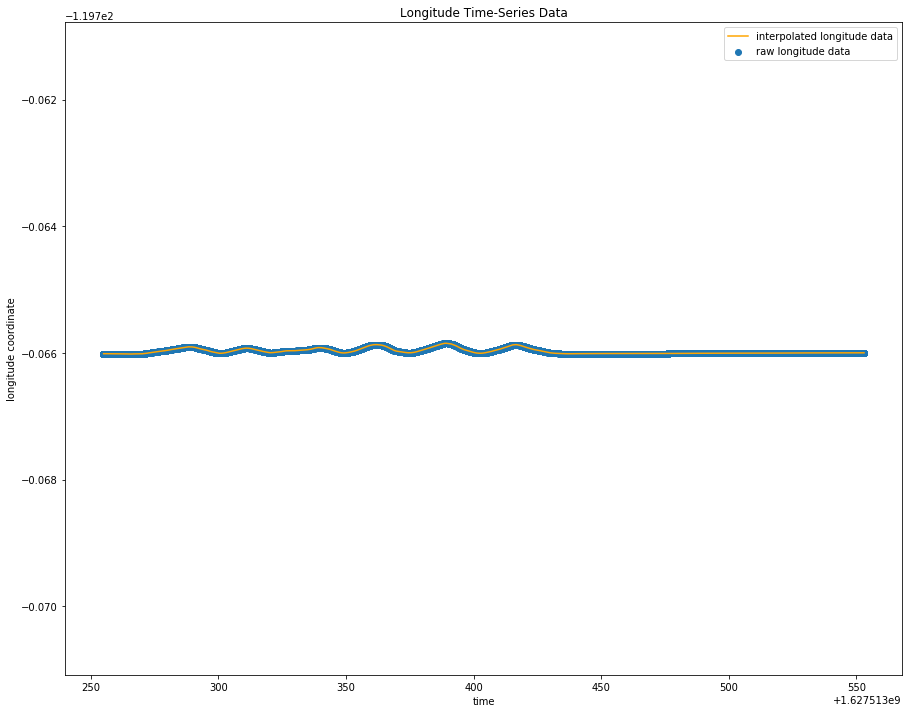

In [22]:
plt.figure(figsize=(15,12))
plt.scatter(DF['gps_time'], DF['lon'], label='raw longitude data')
plt.plot(master_time, interp_gps_lon, color='orange', label='interpolated longitude data')
plt.title("Longitude Time-Series Data")
plt.xlabel("time")
plt.ylabel("longitude coordinate")
plt.legend()
# plt.savefig("lon_time.png")
plt.show()

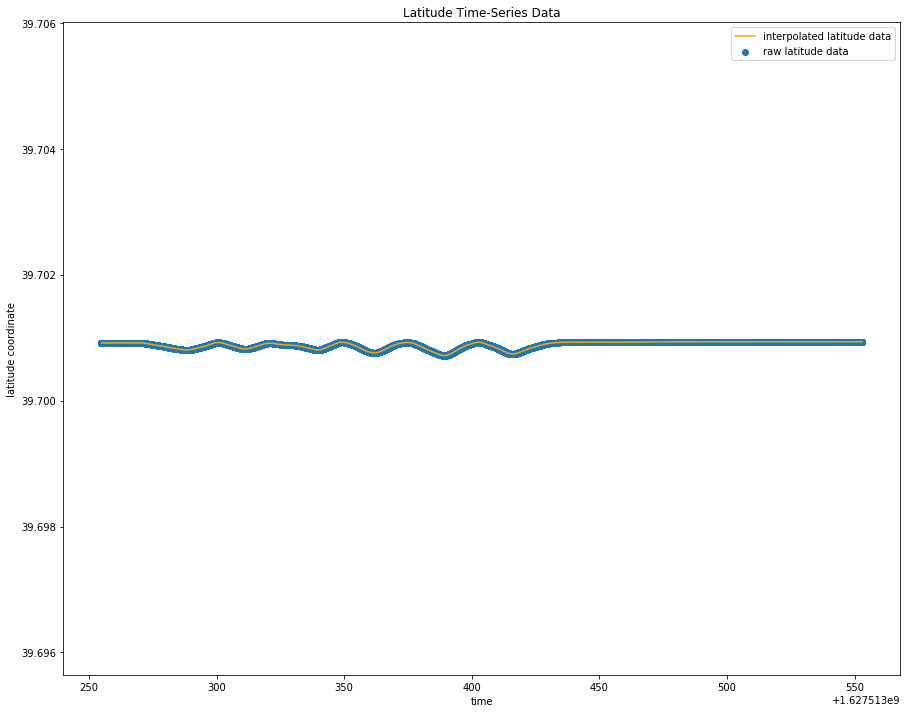

In [23]:
plt.figure(figsize=(15,12))
plt.scatter(DF['gps_time'], DF['lat'], label='raw latitude data')
plt.plot(master_time, interp_gps_lat, color='orange', label='interpolated latitude data')
plt.title("Latitude Time-Series Data")
plt.xlabel("time")
plt.ylabel("latitude coordinate")
plt.legend()
# plt.savefig("lat_time.png")
plt.show()

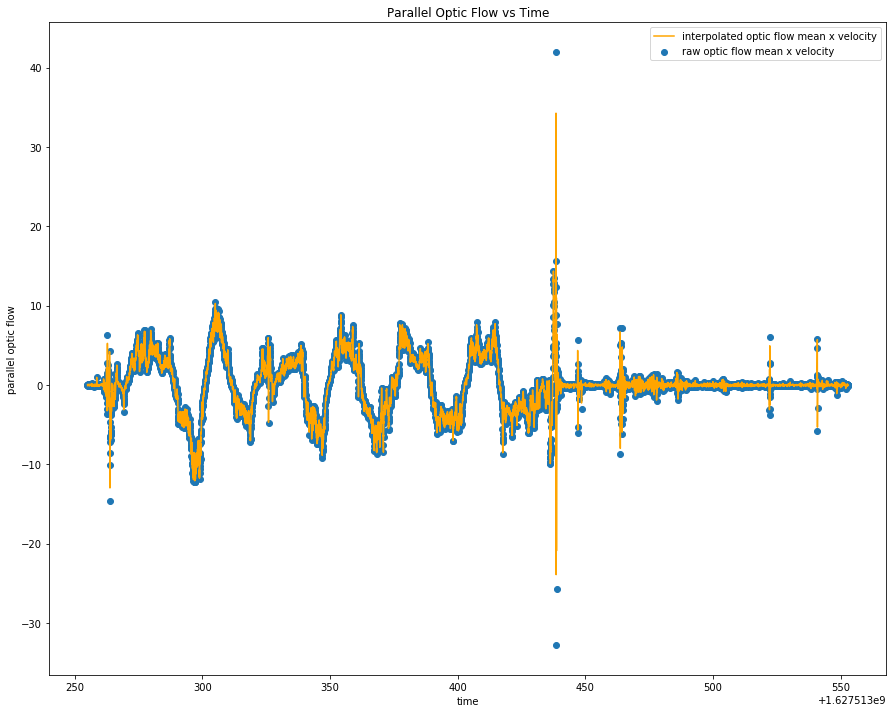

In [24]:
plt.figure(figsize=(15,12))
plt.scatter(DF['OpFlo_vx_time'], DF['OpFlo_vx'], label='raw optic flow mean x velocity')
plt.plot(master_time, interp_opflo_vx, color='orange', label = 'interpolated optic flow mean x velocity')
plt.title("Parallel Optic Flow vs Time")
plt.xlabel("time")
plt.ylabel("parallel optic flow")
plt.legend()
# plt.savefig("op_x_vs_t.png")
plt.show()

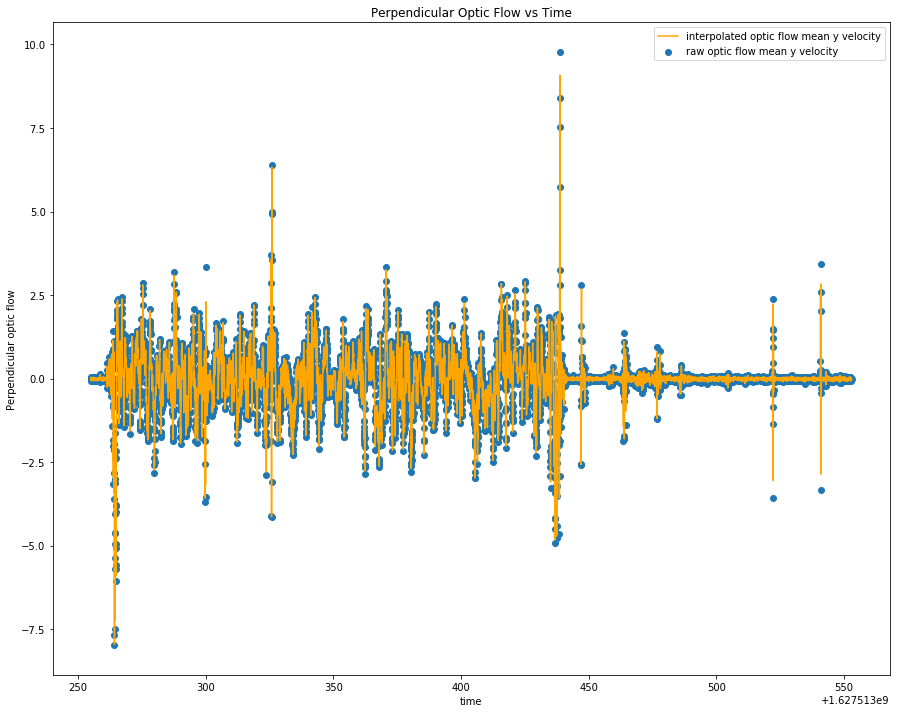

In [25]:
plt.figure(figsize=(15,12))
plt.scatter(DF['OpFlo_vy_time'], DF['OpFlo_vy'], label='raw optic flow mean y velocity')
plt.plot(master_time, interp_opflo_vy, color='orange', label = 'interpolated optic flow mean y velocity')
plt.title("Perpendicular Optic Flow vs Time")
plt.xlabel("time")
plt.ylabel("Perpendicular optic flow")
plt.legend()
# plt.savefig("op_y_vs_t.png")
plt.show()

In [26]:
# plt.figure(figsize=(15,12))
# plt.scatter(DF['imu_time'], DF['orientation_x'], label='imu x orientation')
# plt.plot(master_time, interp_imu_ornt_x, color='orange', label = 'interpolated imu x orientation')
# plt.title("IMU X Orientation vs Time")
# plt.xlabel("time")
# plt.ylabel("x orientation (radians)")
# plt.legend()
# plt.savefig("imu_ornt_x_vs_t.png")
# plt.show()

In [27]:
interp_drone_df = pd.DataFrame({'master_time':master_time,
                                'imu_ang_x':interp_imu_ornt_x,
                                'imu_ang_y':interp_imu_ornt_y,
                                'imu_ang_z':interp_imu_ornt_z,
                               
                                'imu_ang_vel_x':interp_imu_ang_vel_x,
                                'imu_ang_vel_y':interp_imu_ang_vel_y,
                                'imu_ang_vel_z':interp_imu_ang_vel_z,
                               
                                'imu_lin_acc_x':interp_imu_lin_accel_x,
                                'imu_lin_acc_y':interp_imu_lin_accel_y,
                                'imu_lin_acc_z':interp_imu_lin_accel_z,
                               
                                'gps_lon':interp_gps_lon,
                                'gps_lat':interp_gps_lat,
                                'gps_alt':interp_gps_alt,
                               
                                'opflow_ang':interp_opflo_ang,
                                'opflow_mag':interp_opflo_mag,
                                
                                'drone_wind_ang':interp_drone_wind_ang,
                                'drone_wind_mag':interp_drone_wind_mag,
                                'drone_wind_vertical': interp_trison_UD,
                                
                                
                                      
                                'ch0':interp_ch0,
                                'ch1':interp_ch1,
                                'ch2':interp_ch2,
                                'ch3':interp_ch3,
                                'ch4':interp_ch4,
                                'ch5':interp_ch5

                               
#                                 'forward_effort':interp_rc_ch4,
#                                 'arm_switch_pwm':interp_rc_ch5
                               })

In [28]:
stat_wind = wind_df.loc[(wind_df.ground_wind_time >= interp_drone_df.master_time.iloc[0]) &
                        (wind_df.ground_wind_time <= interp_drone_df.master_time.iloc[-1])]

In [29]:
stat_wind

,ground_wind_time,Dir,Speed,Stationary_Vertical_Wind
158293,1.627513e+09,1.326450,1.67,-0.25
158294,1.627513e+09,1.535890,1.78,-0.45
158295,1.627513e+09,1.500983,1.93,-0.13
158296,1.627513e+09,1.570796,1.52,-0.45
158297,1.627513e+09,1.588250,0.81,-0.38
158298,1.627513e+09,1.623156,1.21,-0.29
158299,1.627513e+09,1.658063,1.90,-0.38
158300,1.627513e+09,1.500983,1.76,-0.38
158301,1.627513e+09,1.605703,1.85,-0.23
158302,1.627513e+09,1.378810,1.93,-0.18


In [30]:
interp_drone_df

,ch0,ch1,ch2,ch3,ch4,ch5,drone_wind_ang,drone_wind_mag,drone_wind_vertical,gps_alt,...,imu_ang_vel_z,imu_ang_x,imu_ang_y,imu_ang_z,imu_lin_acc_x,imu_lin_acc_y,imu_lin_acc_z,master_time,opflow_ang,opflow_mag
0,982.0,1495.0,1491.000000,1494.170701,982.0,982.0,-0.927295,0.150000,0.760000,1499.472121,...,0.000123,0.022457,-0.001838,0.608509,0.267970,-0.379917,9.792841,1.627513e+09,2.240463,0.073026
1,982.0,1495.0,1491.000000,1494.593737,982.0,982.0,-1.590521,0.238425,0.720541,1499.472121,...,-0.000718,0.022456,-0.001840,0.608510,0.249508,-0.396107,9.802359,1.627513e+09,-1.666232,0.054163
2,982.0,1495.0,1491.000000,1494.984881,982.0,982.0,-1.397593,0.153681,0.817322,1499.472121,...,0.000622,0.022458,-0.001835,0.608505,0.222253,-0.391042,9.806107,1.627513e+09,-1.326841,0.089676
3,982.0,1495.0,1491.000000,1494.603565,982.0,982.0,-0.795338,0.084022,0.851549,1499.472121,...,-0.000716,0.022454,-0.001835,0.608506,0.230595,-0.392703,9.804091,1.627513e+09,-0.988801,0.069691
4,982.0,1495.0,1491.000000,1494.222249,982.0,982.0,-1.566853,0.099608,0.738731,1499.472121,...,0.000705,0.022449,-0.001832,0.608503,0.232855,-0.390098,9.798398,1.627513e+09,-2.009943,0.050527
5,982.0,1495.0,1491.000000,1494.000000,982.0,982.0,-2.108672,0.288612,0.621690,1499.472121,...,-0.000838,0.022447,-0.001834,0.608505,0.231099,-0.379302,9.776469,1.627513e+09,-2.658446,0.074524
6,982.0,1495.0,1491.000000,1494.000000,982.0,982.0,-2.865142,0.683500,0.405878,1499.472323,...,-0.001589,0.022452,-0.001836,0.608504,0.247596,-0.376436,9.775507,1.627513e+09,-2.055626,0.023481
7,982.0,1495.0,1491.000000,1494.000000,982.0,982.0,-2.708818,0.418737,0.507210,1499.473121,...,-0.000990,0.022458,-0.001836,0.608502,0.265430,-0.384357,9.795900,1.627513e+09,-1.416805,0.040820
8,982.0,1495.0,1491.000000,1494.000000,982.0,982.0,-1.703648,0.156378,0.665715,1499.473121,...,0.000097,0.022459,-0.001832,0.608505,0.251675,-0.387228,9.783452,1.627513e+09,-1.537042,0.080016
9,982.0,1495.0,1491.000000,1494.000000,982.0,982.0,-0.940687,0.124192,0.714548,1499.473121,...,-0.000526,0.022462,-0.001833,0.608507,0.238589,-0.384457,9.790875,1.627513e+09,-1.924751,0.059216


In [31]:
# print(stat_wind.ground_wind_time.values[0])
# interp_drone_df.master_time[0]
df_wind_loc = pd.DataFrame({'wind_time':stat_wind.ground_wind_time, 'Direction':stat_wind.Dir, 'Speed':stat_wind.Speed, 
                            'Stationary_Vertical_Wind':stat_wind.Stationary_Vertical_Wind})
df_new = pd.concat([interp_drone_df, df_wind_loc], sort=True)

In [32]:
comb_time = np.hstack([interp_drone_df.master_time, df_wind_loc.wind_time])

df_new['time']=comb_time
df_new = df_new.sort_values(by=['time'])
dt_drone = np.median(np.diff(df_new.master_time.dropna().values))
dt_ground_wind = np.median(np.diff(df_new.wind_time.dropna().values))
first_time = np.max([df_new.master_time.min(), df_new.wind_time.min()])
last_time = np.min([df_new.master_time.max(), df_new.wind_time.max()])
master_time_2 = np.arange(first_time, last_time, min([dt_drone, dt_ground_wind]))



df_imu_ang_x= df_new[['master_time', 'imu_ang_x']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_ang_x.master_time, df_imu_ang_x.imu_ang_x)
interp_imu_ang_x = func_interp_sensor(master_time_2)

df_imu_ang_y= df_new[['master_time', 'imu_ang_y']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_ang_y.master_time, df_imu_ang_y.imu_ang_y)
interp_imu_ang_y = func_interp_sensor(master_time_2)

df_imu_ang_z= df_new[['master_time', 'imu_ang_z']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_ang_z.master_time, df_imu_ang_z.imu_ang_z)
interp_imu_ang_z = func_interp_sensor(master_time_2)


df_imu_ang_vel_x= df_new[['master_time', 'imu_ang_vel_x']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_ang_vel_x.master_time, df_imu_ang_vel_x.imu_ang_vel_x)
interp_imu_ang_vel_x = func_interp_sensor(master_time_2)

df_imu_ang_vel_y= df_new[['master_time', 'imu_ang_vel_y']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_ang_vel_y.master_time, df_imu_ang_vel_y.imu_ang_vel_y)
interp_imu_ang_vel_y = func_interp_sensor(master_time_2)

df_imu_ang_vel_z= df_new[['master_time', 'imu_ang_vel_z']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_ang_vel_z.master_time, df_imu_ang_vel_z.imu_ang_vel_z)
interp_imu_ang_vel_z = func_interp_sensor(master_time_2)


df_imu_lin_acc_x= df_new[['master_time', 'imu_lin_acc_x']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_lin_acc_x.master_time, df_imu_lin_acc_x.imu_lin_acc_x)
interp_imu_lin_acc_x = func_interp_sensor(master_time_2)

df_imu_lin_acc_y= df_new[['master_time', 'imu_lin_acc_y']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_lin_acc_y.master_time, df_imu_lin_acc_y.imu_lin_acc_y)
interp_imu_lin_acc_y = func_interp_sensor(master_time_2)

df_imu_lin_acc_z= df_new[['master_time', 'imu_lin_acc_z']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_imu_lin_acc_z.master_time, df_imu_lin_acc_z.imu_lin_acc_z)
interp_imu_lin_acc_z = func_interp_sensor(master_time_2)



df_gps_lon= df_new[['master_time', 'gps_lon']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_gps_lon.master_time, df_gps_lon.gps_lon)
interp_gps_lon = func_interp_sensor(master_time_2)

df_gps_lat= df_new[['master_time', 'gps_lat']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_gps_lat.master_time, df_gps_lat.gps_lat)
interp_gps_lat = func_interp_sensor(master_time_2)

df_gps_alt= df_new[['master_time', 'gps_alt']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_gps_alt.master_time, df_gps_alt.gps_alt)
interp_gps_alt = func_interp_sensor(master_time_2)



df_opflo_ang = df_new[['master_time', 'opflow_ang']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_opflo_ang.master_time, df_opflo_ang.opflow_ang)
interp_opflo_ang = func_interp_sensor(master_time_2)

df_opflo_mag = df_new[['master_time', 'opflow_mag']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_opflo_mag.master_time, df_opflo_mag.opflow_mag)
interp_opflo_mag = func_interp_sensor(master_time_2)



df_drone_wind_ang = df_new[['master_time', 'drone_wind_ang']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_drone_wind_ang.master_time, df_drone_wind_ang.drone_wind_ang)
interp_drone_wind_ang = func_interp_sensor(master_time_2)

df_drone_wind_mag = df_new[['master_time', 'drone_wind_mag']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_drone_wind_mag.master_time, df_drone_wind_mag.drone_wind_mag)
interp_drone_wind_mag = func_interp_sensor(master_time_2)

df_drone_wind_vertical = df_new[['master_time', 'drone_wind_vertical']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_drone_wind_vertical.master_time, df_drone_wind_vertical.drone_wind_vertical)
interp_drone_wind_vertical = func_interp_sensor(master_time_2)


df_g_wind_dir = df_new[['wind_time', 'Direction']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_g_wind_dir.wind_time, df_g_wind_dir.Direction)
interp_g_wind_dir = func_interp_sensor(master_time_2)

df_g_wind_spd = df_new[['wind_time', 'Speed']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_g_wind_spd.wind_time, df_g_wind_spd.Speed)
interp_g_wind_spd = func_interp_sensor(master_time_2)

df_g_wind_updown = df_new[['wind_time', 'Stationary_Vertical_Wind']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_g_wind_updown.wind_time, df_g_wind_updown.Stationary_Vertical_Wind)
interp_g_wind_updown = func_interp_sensor(master_time_2)


df_ch0 = df_new[['master_time', 'ch0']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_ch0.master_time, df_ch0.ch0)
interp_ch0 = func_interp_sensor(master_time_2)

df_ch1 = df_new[['master_time', 'ch1']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_ch1.master_time, df_ch1.ch1)
interp_ch1 = func_interp_sensor(master_time_2)

df_ch2 = df_new[['master_time', 'ch2']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_ch2.master_time, df_ch2.ch2)
interp_ch2 = func_interp_sensor(master_time_2)

df_ch3 = df_new[['master_time', 'ch3']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_ch3.master_time, df_ch3.ch3)
interp_ch3 = func_interp_sensor(master_time_2)

df_ch4 = df_new[['master_time', 'ch4']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_ch4.master_time, df_ch4.ch4)
interp_ch4 = func_interp_sensor(master_time_2)

df_ch5 = df_new[['master_time', 'ch5']].dropna()
func_interp_sensor = scipy.interpolate.interp1d(df_ch5.master_time, df_ch5.ch5)
interp_ch5 = func_interp_sensor(master_time_2)


In [39]:
drone_and_ground_data = pd.DataFrame({'master_time':master_time_2,
                                    'imu_ang_x':interp_imu_ang_x,
                                    'imu_ang_y':interp_imu_ang_y,
                                    'imu_ang_z':interp_imu_ang_z,

                                    'imu_ang_vel_x':interp_imu_ang_vel_x,
                                    'imu_ang_vel_y':interp_imu_ang_vel_y,
                                    'imu_ang_vel_z':interp_imu_ang_vel_z,

                                    'imu_lin_acc_x':interp_imu_lin_acc_x,
                                    'imu_lin_acc_y':interp_imu_lin_acc_y,
                                    'imu_lin_acc_z':interp_imu_lin_acc_z,

                                    'gps_lon':interp_gps_lon,
                                    'gps_lat':interp_gps_lat,
                                    'gps_alt':interp_gps_alt,

                                    'opflow_ang':interp_opflo_ang,
                                    'opflow_mag':interp_opflo_mag,

                                    'drone_wind_ang':interp_drone_wind_ang,
                                    'drone_wind_mag':interp_drone_wind_mag,
                                    'drone_wind_vertical': interp_drone_wind_vertical,
                                      
                                    'ch0':interp_ch0,
                                    'ch1':interp_ch1,
                                    'ch2':interp_ch2,
                                    'ch3':interp_ch3,
                                    'ch4':interp_ch4,
                                    'ch5':interp_ch5,
                                     
                                     
                                     'D':interp_g_wind_dir,
                                     'S':interp_g_wind_spd,
                                     'Stationary_Vertical_Wind': interp_g_wind_updown})
drone_and_ground_data.to_hdf(preprocessed_data_home_folder_name + '/' + folder_name + '_interpolated.h5', key='drone_and_ground_data', mode='w')

In [40]:
drone_and_ground_data.keys()

Index(['D', 'S', 'Stationary_Vertical_Wind', 'ch0', 'ch1', 'ch2', 'ch3', 'ch4',
       'ch5', 'drone_wind_ang', 'drone_wind_mag', 'drone_wind_vertical',
       'gps_alt', 'gps_lat', 'gps_lon', 'imu_ang_vel_x', 'imu_ang_vel_y',
       'imu_ang_vel_z', 'imu_ang_x', 'imu_ang_y', 'imu_ang_z', 'imu_lin_acc_x',
       'imu_lin_acc_y', 'imu_lin_acc_z', 'master_time', 'opflow_ang',
       'opflow_mag'],
      dtype='object')

In [41]:
drone_and_ground_data[drone_and_ground_data.ch5 > 1000]
# drone_and_ground_data.to_hdf("../" + )

,D,S,Stationary_Vertical_Wind,ch0,ch1,ch2,ch3,ch4,ch5,drone_wind_ang,...,imu_ang_vel_z,imu_ang_x,imu_ang_y,imu_ang_z,imu_lin_acc_x,imu_lin_acc_y,imu_lin_acc_z,master_time,opflow_ang,opflow_mag
249,1.418013,0.698007,-0.457998,982.000000,1495.0,1491.000000,1494.000000,982.0,1288.043992,-1.347640,...,0.000724,0.022025,-0.002066,0.607830,0.224911,-0.380201,9.784980,1.627513e+09,-1.853741,0.043719
250,1.414526,0.594103,-0.483974,982.000000,1495.0,1491.000000,1494.000000,982.0,1633.127180,-0.744349,...,0.000140,0.022019,-0.002061,0.607829,0.222424,-0.384641,9.779168,1.627513e+09,-1.473425,0.036978
251,1.550317,0.588416,-0.451634,982.000000,1495.0,1491.000000,1494.000000,982.0,1978.810188,-0.508717,...,-0.000410,0.022018,-0.002057,0.607829,0.231950,-0.381456,9.787624,1.627513e+09,0.011775,0.007554
252,1.728175,0.612393,-0.401681,982.000000,1495.0,1491.000000,1494.000000,982.0,2006.000000,-0.239838,...,0.000490,0.022024,-0.002054,0.607824,0.253620,-0.377156,9.801582,1.627513e+09,1.963707,0.032903
253,1.906034,0.636371,-0.351727,982.000000,1495.0,1491.000000,1494.000000,982.0,2006.000000,0.107102,...,-0.000523,0.022023,-0.002054,0.607824,0.226905,-0.394597,9.790831,1.627513e+09,2.057006,0.054824
254,2.083892,0.660349,-0.301773,982.000000,1495.0,1491.000000,1494.000000,982.0,2006.000000,0.269205,...,0.000186,0.022018,-0.002057,0.607824,0.225221,-0.390285,9.772178,1.627513e+09,1.775155,0.055962
255,2.261751,0.684326,-0.251820,982.000000,1495.0,1491.000000,1494.000000,982.0,2006.000000,0.252576,...,-0.001576,0.022013,-0.002060,0.607826,0.243935,-0.382299,9.768369,1.627513e+09,1.742301,0.027875
256,2.277212,0.773894,-0.188138,982.000000,1495.0,1491.000000,1494.000000,982.0,2006.000000,0.128887,...,-0.000307,0.022018,-0.002061,0.607824,0.248794,-0.394363,9.818766,1.627513e+09,-1.566642,0.067395
257,2.242338,0.883792,-0.120201,982.000000,1495.0,1491.000000,1494.000000,982.0,2006.000000,0.123338,...,-0.000427,0.022007,-0.002055,0.607826,0.232502,-0.391849,9.807814,1.627513e+09,-2.193190,0.037658
258,2.207464,0.993690,-0.052264,982.000000,1495.0,1491.000000,1494.000000,982.0,2006.000000,0.098394,...,0.000377,0.022005,-0.002043,0.607824,0.217895,-0.383311,9.803336,1.627513e+09,2.296410,0.021838


In [43]:
preprocessed_data_home_folder_name + '/' + folder_name + '_interpolated.h5'

'../data_experiments_preprocessed/BOTFLY_DATA_2021-07-28-16-00-54_interpolated.h5'